This project is a study on VaR and fat-tail risks, through the creation of a Markowitz optimized portfolio.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import cvxopt as opt
from cvxopt import blas, solvers
import datetime
import random
import pandas_ta as ta

np.random.seed(123)

# Desligando os prints de progresso 
solvers.options['show_progress'] = False

import plotly.express as px
import cufflinks

### Creating the portfolio

Getting the data in an optimized way, through the use of a loop:

In [2]:
tickers = ["PETR4.SA","VALE3.SA","ITUB4.SA", "BBAS3.SA", "BBDC4.SA", "ABEV3.SA"]
d = {name: pd.DataFrame() for name in tickers}
raw = {name: pd.DataFrame() for name in tickers}
df = {name: pd.DataFrame() for name in tickers}
final = {name: pd.DataFrame() for name in tickers}, 

import yahoofinancials as yf

start_date = '2012-04-29'
end_date =  '2022-04-29'

for i in range(0,len(tickers)):

    d[i] = yf.YahooFinancials(tickers[i]).get_historical_price_data(start_date, end_date, 'monthly')

    # Ler os dados do JSON
    raw[i] = pd.DataFrame(d[i][tickers[i]]['prices']).dropna()
    # Converter a data para o tipo correto datetime
    raw[i]['formatted_date'] = pd.to_datetime(raw[i]['formatted_date'])
    # Indica a data como o índice de cada linha
    raw[i] = raw[i].set_index('formatted_date')

    # Final
    del raw[i]["date"]

### Returns and standard deviation

Calculated through the use of adjusted closes, with logarithmic returns.

In [3]:
for n in range(0,len(tickers)):
    #Criando retornos e sua coluna
    raw[n]["logret{0}".format(n)]=np.log1p(raw[n]["adjclose"].pct_change())

### Plotting returns

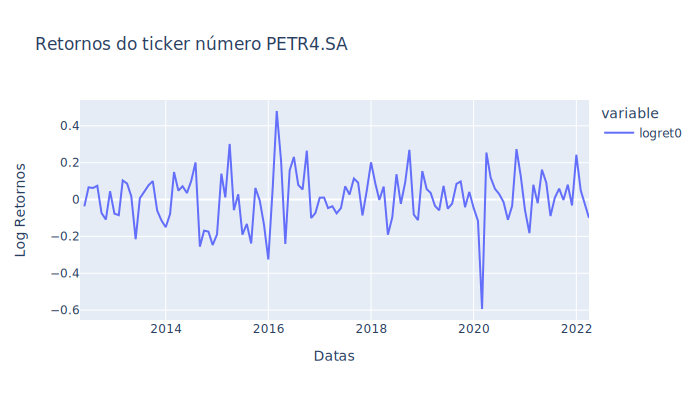

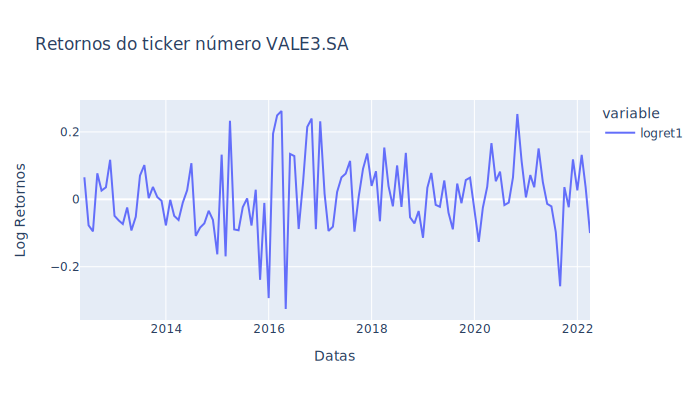

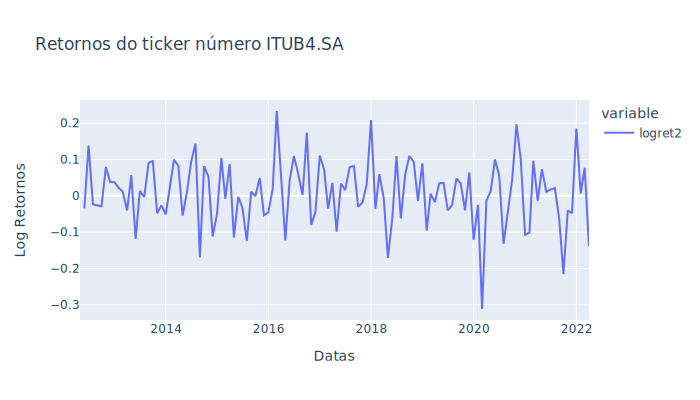

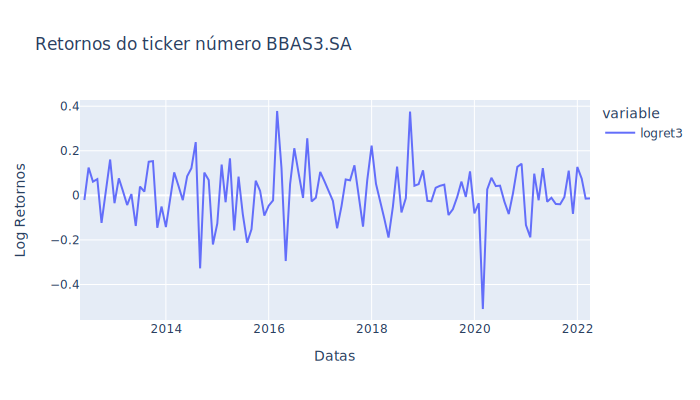

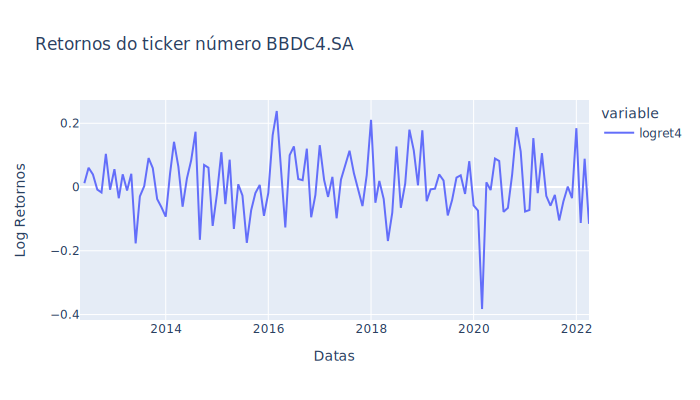

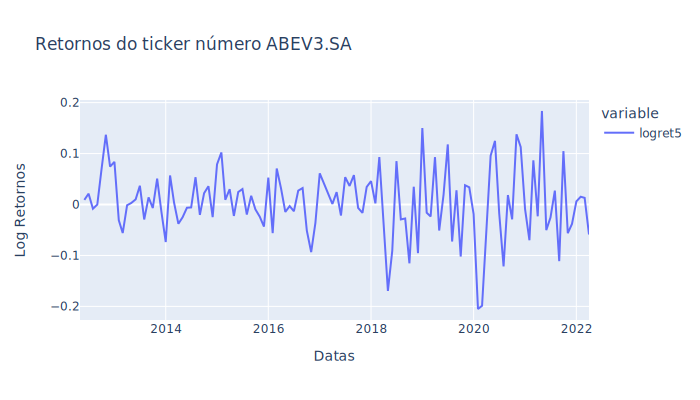

In [22]:
for n in range(0,len(tickers)):
    fig = px.line(raw[n]["logret{0}".format(n)],
                  title = "Retornos do ticker número {0}".format(tickers[n]),
                  labels={'formatted_date':'Datas', 'value':'Log Retornos'},
                  height = 400)
    fig.show("svg")

### Function creations

In [5]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

Adicionar nova variável de retornos, criar retornos n vezes de acordo com o n de simulações

In [6]:
def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''

    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

### Return array for function usage

In [7]:
ret = []

for n in range(0,len(tickers)):
    ret.append(raw[n]["logret{0}".format(n)].dropna())
    
ret = np.array(ret)

### Markowitz Porfolio

In [8]:
n_portfolios = int(input("How many simulations do you wish to create? "))
means, stds = np.column_stack([random_portfolio(ret) for _ in range(n_portfolios)])

How many simulations do you wish to create? 500


In [9]:
means = np.concatenate(means, axis=0)
stds = np.concatenate(stds, axis=0)

In [10]:
RandomGen = pd.DataFrame()

risks = np.array(stds)
risks = risks.reshape(-1, )
returns = np.array(means)
returns = returns.reshape(-1, )

RandomGen[0] = risks
RandomGen[1] = returns

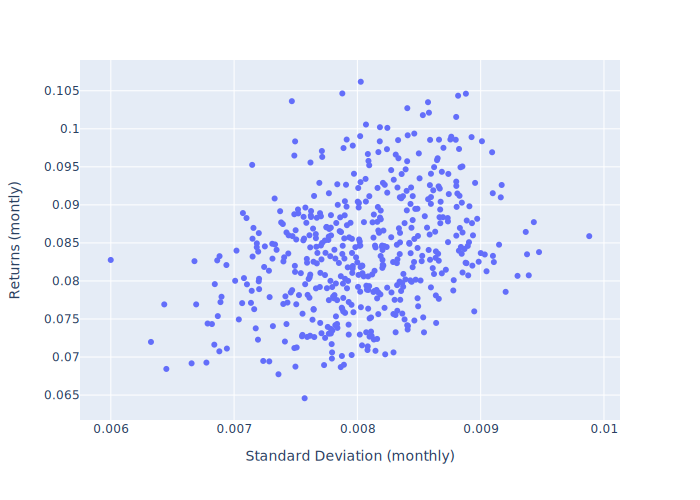

In [21]:
fig = px.scatter(x = means, y = stds, labels = {'x': "Standard Deviation (monthly)", 'y': "Returns (montly)"})
fig. show("svg")

### Optimal portfolio creation

In [12]:
def optimal_portfolio(ret):
    n = len(ret)
    returns = np.asmatrix(ret)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(ret))
    pbar = opt.matrix(np.mean(ret, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    
    return np.asarray(wt), returns, risks, portfolios

weights, returns, risks, portfolios = optimal_portfolio(ret)

In [13]:
RandomGen2 = pd.DataFrame()

risks = np.array(risks)
risks = risks.reshape(-1, )
returns = np.array(returns)
returns = returns.reshape(-1, )

RandomGen2[0] = risks
RandomGen2[1] = returns

### Sharpe Ratio

In [14]:
riskfree = float(input("What's the risk free return of the chosen portfolio? (use decimals) :"))
riskfree = riskfree ** 1/12

What's the risk free return of the chosen portfolio? (use decimals) :0.05


In [15]:
sharpe = []
sharpe = (returns - riskfree)/risks
RandomGen2[2] = sharpe
xsharpe = RandomGen2[2].idxmax()

In [16]:
RandomGen2[2][xsharpe]

0.07086768339148632

### Sharpe portfolio

In [23]:
sharpeportfolio = np.asarray(portfolios[xsharpe]).reshape(-1,)*100

### Efficient Frontier

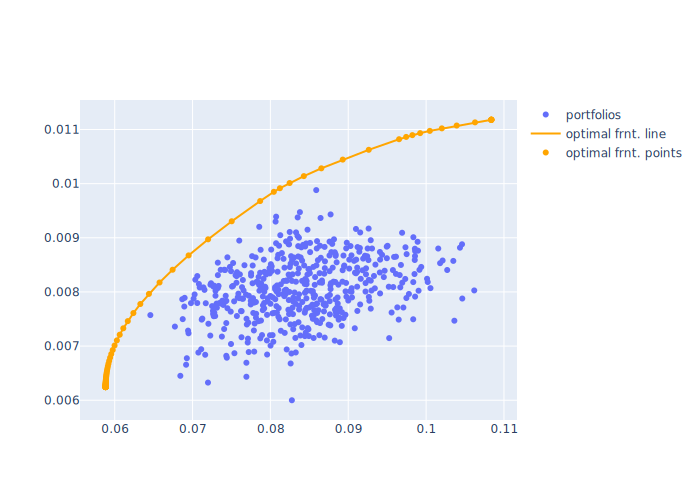

In [18]:
import plotly.graph_objects as go

fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=RandomGen[0], y=RandomGen[1],mode='markers',name='portfolios'))

fig.add_trace(go.Scatter(x=RandomGen2[0], y=RandomGen2[1], mode='lines',name='optimal frnt. line', marker=dict(color="Orange")))

fig.add_trace(go.Scatter(x=RandomGen2[0], y=RandomGen2[1], mode="markers",name='optimal frnt. points', marker=dict(color="Orange")))

fig.show("svg")

### So, what's the best alternative?

If you wish to buy only one stock, which has the minimum std, then use this:

In [19]:
weights = weights.reshape(-1,)

optchoice = dict(zip(tickers, weights*100))
optchoice = pd.DataFrame(optchoice, index = [1])
optchoice

,PETR4.SA,VALE3.SA,ITUB4.SA,BBAS3.SA,BBDC4.SA,ABEV3.SA
1,0.000014,99.999939,0.000018,0.000004,0.000017,0.000008


If you wish to buy a portfolio according to the best sharpe ratio, then use this:

In [29]:
portfoliosharpe = dict(zip(tickers, sharpeportfolio))
portfoliosharpe = pd.DataFrame(portfoliosharpe, index = [1])
portfoliosharpe["Sharpe"] = RandomGen2[2][xsharpe]
portfoliosharpe["Monthly Return"] = RandomGen2[1][xsharpe]
portfoliosharpe["Monthly Std. dev."] = RandomGen2[0][xsharpe]
portfoliosharpe

,PETR4.SA,VALE3.SA,ITUB4.SA,BBAS3.SA,BBDC4.SA,ABEV3.SA,Sharpe,Monthly Return,Monthly Std. dev.
1,0.000003,58.646461,39.716105,1.637363,0.000058,0.000009,0.070868,0.010011,0.082471
